Conda environment: scikitenv

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdmolops,Draw,Descriptors, Descriptors3D
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC,LinearSVR
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression,BayesianRidge
from statistics import mean

import matplotlib.pyplot as plt
import numpy as np
import random, os, re, statistics, copy,pickle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import itertools
import shap
import seaborn as sns

In [ ]:
def prep_data(dataset:pd.DataFrame,returnscaler:bool=False):
    """Normalize X data and return scaled X and Y dataframes
    Returns two dataframes"""
    X_data = dataset.iloc[:,:-1]
    Y_data = pd.DataFrame(dataset.iloc[:,-1])

    scaler = preprocessing.StandardScaler().fit(X_data)
    X_scaled = pd.DataFrame(scaler.transform(X_data))
    
    if returnscaler:
        return X_scaled, Y_data.reset_index(drop=True),scaler
    return X_scaled, Y_data.reset_index(drop=True)

def averagebetween2lists(ls1:list,ls2:list)->list:
    """Take two equal length lists and average their values iteratively
    Returns list"""
    return [mean([x,ls2[n]]) for n,x in enumerate(ls1)]
        

def specificTRAINTEST(trainx:pd.DataFrame,trainy:pd.DataFrame,testx:pd.DataFrame,testy:pd.DataFrame,cycles:int=1,parameters=None):
    """Taking training and testing data input, train model and make prediction.
    Returns results and accuracy metrics"""
    r2 = []
    mae = []
    preds = []
    feature_importances = []
    for n in range(cycles): ### each cycle runs a different random state
        ### Use custom hyperparameters
        if parameters:
            rfreg = RandomForestRegressor(random_state=n,**parameters)
        else:
            rfreg = RandomForestRegressor(random_state=n)
        rfreg.fit(trainx, np.ravel(trainy)) ### Fit/train model
        feature_importances.append(rfreg.feature_importances_) ### Get feature importance (SciKit Learn method)
        y_pred = rfreg.predict(testx) ### Use trained model to make predictions
        score_r2 = r2_score(testy, y_pred) ### R2 score
        score_mae = mean_absolute_error(testy, y_pred) ### MAE score
        ### Append predictions and accuracy metrics
        preds.append(zip([testy,y_pred]))
        r2.append(score_r2)
        mae.append(score_mae)
    return r2,mae,preds,feature_importances,rfreg


def swap_sections(df:pd.DataFrame, section1:int, section2:int, features_per_section:int=7)->pd.DataFrame:
    """Take a dataframe, and swap parts of a dataframe. This useful for creating an inverse dataset.
    For example, if df has 12 features. We can swap sections 0,1 and 2,3 by doing:
    swap_sections(df,0,1,2)
    This works because we take section1 (0) and its end which is (0+1)*2 == 2. 2 is non-inclusive because
    we index a list.
    Returns dataframe"""
    ### Get column ranges that will be swapped
    start_1, end_1 = section1 * features_per_section, (section1 + 1) * features_per_section
    start_2, end_2 = section2 * features_per_section, (section2 + 1) * features_per_section
    
    ### Reorganize columns
    new_colorder = list(df.columns[:start_1]) + list(df.columns[start_2:end_2]) + list(df.columns[end_1:start_2]) + list(df.columns[start_1:end_1]) + list(df.columns[end_2:])
    ### Return updated dataframe with reorganized columns
    return df[new_colorder]


def test_all(num:int,dataset:pd.DataFrame):
    """Iterate through entire dataset and use 1 molecule (and its inversed vector if applicable) 
    as testing set. All the results, predictions, models, and feature importances are collated.
    
    If an inverse dataframe (molecule vectors + inversed molecule vectors) is used, the num variable
    should be half the size of dataset.shape[0]
    Returns MAE and R2, MAE, feature importance, predictions, and models"""
    results = {}
    maeresults = {}
    featureimportances = {}
    allpreds = []
    models = []
    for n in range(num):
        print(n,end='\r')
        ### For each row in dataframe, set row and inverse molecule vector (if applicable) as testing set
        testset = [n,n+num]
        ### Normalize data
        X_scaled, Y_scaled = prep_data(dataset)
        ### Get training and testing data. scramble dataframes using same random_state for consistency
        ### This should not be done earlier because we need the testset variable to find the correct rows!
        X_scaled_train = X_scaled[~X_scaled.index.isin(testset)]
        X_scaled_train = X_scaled_train.sample(frac=1,random_state=0)
        X_scaled_test = X_scaled[X_scaled.index.isin(testset)]
        X_scaled_test = X_scaled_test.sample(frac=1,random_state=0)
        Y_scaled_train = Y_scaled[~Y_scaled.index.isin(testset)]
        Y_scaled_train = Y_scaled_train.sample(frac=1,random_state=0)
        Y_scaled_test = Y_scaled[Y_scaled.index.isin(testset)]
        Y_scaled_test = Y_scaled_test.sample(frac=1,random_state=0)
        
        r2,mae,preds,feature_importances,rfreg = specificTRAINTEST(X_scaled_train,Y_scaled_train,X_scaled_test,Y_scaled_test,cycles=1)
        featureimportances[n+1] = feature_importances
        predls = [list(z) for z in preds]
        allpreds.append(predls)
        maeresults[n+1] = [mean(r2),mean(mae)]
        results[n+1] = mae
        models.append(rfreg)
#         print('r2',mean(r2))
#         print('mae',mean(mae))
    return maeresults,results, featureimportances,allpreds,models


def plot_dict_first_elements2(data_dict:dict, figsize:tuple=(8, 6), ylims:tuple=None, xlims:tuple = None):
    """data_dict contains structure IDs as the key and MAEs as the values."""
    ### X values 
    x_values = list(data_dict.keys())
    y_values = list(data_dict.values())
    
    ### Plot
    plt.figure(figsize=figsize)
    plt.errorbar(x_values, y_values, fmt='o', color='b', capsize=5)
    
    ### Label the plot and x axis
    plt.xlabel('Structure ID')
    plt.ylabel('MAE')
    plt.title(f'Plot of MAE for each structure as isolated test set')
    plt.xticks(x_values, rotation=85)
    
    ### Configure x and y axis limits
    if ylims is not None:
        plt.ylim(ylims)
    plt.xlim((min(x_values)-1,max(x_values)+1))
    plt.grid(True)
    
    plt.show()

def test_kfolds(dataset:pd.DataFrame,k_folds:int=5,cycles:int=1):
    """This does kfolds testing of a model but assumes there are no inversed molecule vectors.
    return r2/MAE results, feature importances, predictions, models, and datasets"""
    results = {}
    featureimportances = {}
    allpreds = []
    models = []
    datasets = []
    
    ### Set up Kfolds splitter
    kfold = KFold(n_splits=k_folds,shuffle=True,random_state=0)

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        ### Normalize data
        X_scaled, Y_scaled = prep_data(dataset)
        ### Prepare training and testing data
        X_scaled_train = X_scaled[~X_scaled.index.isin(test_ids)]
        X_scaled_train = X_scaled_train.sample(frac=1,random_state=0)
        X_scaled_test = X_scaled[X_scaled.index.isin(test_ids)]
        X_scaled_test = X_scaled_test.sample(frac=1,random_state=0)
        Y_scaled_train = Y_scaled[~Y_scaled.index.isin(test_ids)]
        Y_scaled_train = Y_scaled_train.sample(frac=1,random_state=0)
        Y_scaled_test = Y_scaled[Y_scaled.index.isin(test_ids)]
        Y_scaled_test = Y_scaled_test.sample(frac=1,random_state=0)
        
        ### Using data, train and test model
        r2,mae,preds,feature_importances,rfreg = specificTRAINTEST(X_scaled_train,Y_scaled_train,X_scaled_test,Y_scaled_test,cycles=cycles)
        print(f'Results \nR2: {np.mean(r2):.2f} ± {np.std(r2):.2f}\nMAE: {np.mean(mae):.2f} ± {np.std(mae):.2f}')
        
        ### Store feature importance, predictions, model, datasets, and r2/MAE scores
        featureimportances[fold] = feature_importances
        allpreds.append([list(z) for z in preds])
        models.append(rfreg)
        datasets.append([X_scaled_train,Y_scaled_train,X_scaled_test,Y_scaled_test])
        results[fold] = [r2,mae]

    return results, featureimportances,allpreds,models,datasets


def test_kfoldsINVERSE(dataset:pd.DataFrame,datainverse:pd.DataFrame,k_folds:int=5,cycles:int=1):
    """This does kfolds testing of a model but assumes there ARE inversed molecule vectors.
    return r2/MAE results, feature importances, predictions, models, and datasets"""
    results = {}
    featureimportances = {}
    allpreds = []
    models = []
    datasets = []
    
    ### Set up Kfolds splitter
    kfold = KFold(n_splits=k_folds,shuffle=True,random_state=0)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold}')
        print('--------------------------------')
        ### Training and testing IDs come from dataset because this contains no inverse vector examples
        ### These sets are then adjusted to include the inverse data (which are in the same position,
        ### just concatenated below)
        train_ids = list(train_ids) +[x +dataset.shape[0] for x in train_ids]
        test_ids = list(test_ids) + list([x +dataset.shape[0] for x in test_ids])
        ### Normalize data
        X_scaled, Y_scaled = prep_data(datainverse)
        X_scaled_train = X_scaled[~X_scaled.index.isin(test_ids)]
        X_scaled_train = X_scaled_train.sample(frac=1,random_state=0)
        X_scaled_test = X_scaled[X_scaled.index.isin(test_ids)]
        Y_scaled_train = Y_scaled[~Y_scaled.index.isin(test_ids)]
        Y_scaled_train = Y_scaled_train.sample(frac=1,random_state=0)
        Y_scaled_test = Y_scaled[Y_scaled.index.isin(test_ids)]

        ### Using data, train and test model
        r2,mae,preds,feature_importances,rfreg = specificTRAINTEST(X_scaled_train,Y_scaled_train,X_scaled_test,Y_scaled_test,cycles=cycles)
        print(f'Results.\nR2: {np.mean(r2):.2f} ± {np.std(r2):.2f}\nMAE: {np.mean(mae):.2f} ± {np.std(mae):.2f}')
        
        ### Store feature importance, predictions, model, datasets, and r2/MAE scores
        featureimportances[fold] = feature_importances
        allpreds.append([list(z) for z in preds])
        models.append(rfreg)
        datasets.append([X_scaled_train,Y_scaled_train,X_scaled_test,Y_scaled_test,train_ids,test_ids])
        results[fold] = [r2,mae]

    return results, featureimportances,allpreds,models,datasets

def test_new_molecule(mol_substituents:list,training_df:pd.DataFrame,smiles2sub_converter:dict,modelparams:dict=None):
    """Take a molecule (represented as as list of substituents) and make a barrier height prediction.
    The molecule substituent list, training data (our entire dataset), a dictionary converting colloqiual 
    name to SMILES, and any additional RF parameterse if neccesary are required."""
    ### Scramble rows and scale data
    X_scaled, Y_scaled, scaler = prep_data(training_df.sample(frac=1,random_state=0),True)
    ### Set up molecule
    if modelparams:
        rfreg = RandomForestRegressor(random_state=0,**modelparams)
    else:
        rfreg = RandomForestRegressor(random_state=0)
    rfreg.fit(X_scaled, np.ravel(Y_scaled)) ### Fit/train model
    ### Convert colloqiual substituent name to SMILES
    mol_substituents = [smiles2sub_converter[x] for x in mol_substituents] 
    ### Using substituents, assemble the feature vector, and scale it
    bh_feat = [list(dubresults[x.split()[-1]].values())+list(hammetls[x]) + list(aromLoss[x]) + list(rdkitfeatures9[x])  for x in mol_substituents] 
    bh_feat = pd.DataFrame([x for y in bh_feat for x in y]).T ### unpack nested lists, turn into dataframe, and switch axis of dataframe
    bh_feat = pd.DataFrame(scaler.transform(bh_feat))
    
    y_pred = rfreg.predict(bh_feat)[0] ### Use trained model to make predictions
    print(round(y_pred,1))
    return y_pred


# 1) Prepare BH Dataset

In [ ]:
dataset = {'1_C=CC(C=C)=O':[15.8,14.8],
           '2_C=CC(C(C)=C)=O':[13.9,12.8],
           '3_C=C(C)C(C(C)=C)=O':[9.7,9.7],
           '4_C=C(C)C(/C(C)=C/C)=O':[10.6,10.6],
           '5_O=C(/C(C)=C/C)/C(C)=C/C':[11.9,11.9],
           '6_O=C(/C(C)=C/C)/C(C)=C(C)/C':[11.1,11.1],
           '7_O=C(/C(C)=C(C)/C)/C(C)=C(C)/C':[13.4,11.9],
           '8_CC(C(C1=CC=CC=C1)=O)=C':[21,21],
           '9_C/C(C)=C(C(C2=CC=CC=C2)=O)/C':[20.5,20.5],
           '10_O=C(C3=CC=CC=C3)C4=CC=CC=C4':[30.5,30.5],
           '11_C=C(C)C(C(OC)=C)=O':[11.4,11.4],
           '12_C=C(C)C(C(C(OC)=O)=C)=O':[13.6,13.6],
           '13_C=C(C)C(/C(OC)=C/C(OC)=O)=O':[9.3,9.3],
           '14_C=C(C(OC)=O)C(C(OC)=C)=O':[11.9,11.9],
           '15_O=C(/C(C)=C(C)/C)/C(C)=C(C)/C1=CC=CC=C1':[12.7,12.7],
           '16_O=C(/C(C)=C(C)/C)/C(C)=C(C2=CC=CC=C2)/C':[15.2,15.1],
           '17_C=CC(/C=C/C3=CC=CC=C3)=O':[21.3,19.4],
           '18_C=CC(/C=C\C4=CC=CC=C4)=O':[22.2,20.0],
           '19_C=CC(/C(C(OC)=O)=C/OC)=O':[17.3,17.3],
           '20_O=C(/C(C)=C(C)/OC)/C(C)=C(C)\C':[16.3,15.5],
           '21_O=C(/C(OC)=C(C)/C(OC)=O)/C(C)=C(C)\C':[10.7,10.4],
           '22_O=C(/C(OC)=C(C)/C)/C(C)=C(C)\C':[12.0,9.8],
           '23_O=C(/C(C(OC)=O)=C(C)/C)/C(C)=C(C)\C':[15.6,15.1],
           '24_O=C(/C(OC)=C(C(OC)=O)/C)/C(C)=C(C)\C':[9.2,8.8],
           '25_O=C(/C(C)=C\C)/C(C)=C\C':[15.9,15.9],
           '26_O=C(/C=C(C)\C)/C=C(C)\C':[30.2,27.2],
           '27_O=C(/C=C\C)/C=C\C':[27.1,24.8],
           '28_O=C(/C=C/C)/C=C/C':[21.9,20.1],
           '29_C=CC(C(OC)=C)=O':[15.2,12.2],
           '30_C=CC(C(C(OC)=O)=C)=O':[18.9,17.3],
           '31_C=CC(/C(C)=C(C)/C)=O':[16.1,14.3],
           '32_C=CC(/C=C(C)/C)=O':[24.4,21.1],
           '33_O=C(/C(C)=C(C)/C)/C(C)=C(CC)/C':[12.5,11.5],
           '34_O=C(/C(C)=C(C)/C)/C(C)=C(C(C)C)/C':[14.3,13.2],
           '35_O=C(/C(C)=C(C)/C)C1=C(C)CCCC1':[14.8,14.4],
           '36_O=C(/C(C)=C(C)/C)C1=C(C(C)C)CCCC1':[15.2,14.3],
           '37_C=C(C)C(C(SC)=C)=O':[7.5,7.5],
           '38_C=C(C)C(C(C#N)=C)=O':[11.3,11.2],
           '39_O=C(/C(C)=C(C#N)/C)/C(C)=C(C)/O':[18.6,18.2],
           '40_O=C(/C(C)=C(C#N)/C)/C(C)=C(C)/C':[15.8,15.8],
           '41_O=C(/C(OC)=C(C)/C)/C(C(OC)=O)=C(C)\C':[12.0,10.5],
           '42_O=C(/C(C)=C(C)/C#N)/C(C)=C(C)/C':[16.2,15.7],
           '43_O=C(/C(SC)=C(C)/C)/C(C)=C(C)\C':[11.2,9.5],
           '44_O=C(/C(SC)=C(C(OC)=O)/C)/C(C)=C(C)\C':[10.2,8.5],
           '45_C/C(C)=C(C(C1=CC=CC=C1)=O)/SC':[20.5,20.5],
           '46_C=C(C#N)C(C(OC)=C)=O':[11.8,11.8],
           '47_O=C(/C(C)=C(C)/CC)C1=C(C)CCCC1':[13.9,13.8],
           '48_O=C(/C(C)=C(C)/CC)C1=C(C(C)C)CCCC1':[15.0,14.0],
           '49_O=C(/C(C)=C(C)/COC1=CC(OC)=CC(OC)=C1)/C(C)=C(C)/C2=CC=CC=C2':[13.5,13.5],
           '50_O=C(/C(C)=C(C)/COC1=CC(OC)=CC(OC)=C1)/C(C)=C(C2=CC=CC=C2)/C':[15.6,15.6],
           '51_O=C(/C(C)=C(COC1=CC(OC)=CC(OC)=C1)/C)/C(C)=C(C)/C2=CC=CC=C2':[10.4,8.7],
           '57_O=C(/C(C)=C(C)\C)C1=CCCC1':[14.7,14.7],
           '58_C=CC(C1=CCCC1)=O':[18.3,16.5],
           '59_O=C(/C(C)=C(C)\C)C1=C(C)CCCO1':[14.7,14.5],
           '60_O=C(C=C)C1=CCCCO1':[15.1,12.6],
           '61_C=CC(C1=CNC=C1)=O':[23.1,22.0],
           '62_C=CC(C1=CC=CN1)=O':[27.0,24.8],
           '63_O=C(C1=CNC=C1)C2=CNC=C2':[33.1,32.7],
           '64_C=CC(/C=C/C1=COC=C1)=O':[22.5,20.6],
           '65_O=C(/C(C)=C(C)/C1=COC=C1)/C(C)=C(C)/C':[11.4,11.4],
           '66_C=CC(C(C1=CC=CO1)=C)=O':[10.5,10.1],
           '67_C=CC(C(C1=COC=C1)=C)=O':[11.3,10.7],
           '68_C=CC(/C=C/[Si](C)(C)C)=O':[15.4,13.9],
           '69_C=CC(C(P(OC)(OC)=O)=C)=O':[19.6,19.6],
           '70_O=C(/C=C(C)/C1=CC=CC=N1)/C=C(C)\C':[28.0,25.7],
           '71_O=C(/C=C(C)/C1=CC=NC=C1)/C=C(C)\C':[28.7,25.9],
           '72_O=C(/C=C(C)/C1=CC=CN=C1)/C=C(C)\C':[28.8,26.0],
           '73_C=CC(C=C=C)=O':[15.8,12.6],
           '75_C=CC(C([Si](C)(C)C)=C)=O':[12.9,12.9],
           '76_C=CC(/C=C/P(OC)(OC)=O)=O':[18.4,16.6],
           '77_O=C(C1=CCCC1)C2=CCCC2':[17.7,17.7],
           '78_C=CC(C1=COC=C1)=O':[20.1,19.4],
           '79_C=CC(C1=CC=CO1)=O':[28.3,25.7],
           '80_O=C(/C(C)=C(C)/C)C1=COC=C1':[16.1,16.1],
           '81_O=C(C1=CC=NC=C1)C2=CC=NC=C2':[36.0,36.0],
           '82_O=C(C1=CC=NC=N1)C2=CC=NC=N2':[41.2,37.8],
           '83_C=CC(C1=CC(OC)=CC(OC)=C1)=O':[17.9,17.5],
           '84_O=C(/C(C)=C(C)/C)C1=CC(OC)=CC(OC)=C1':[13.5,13.5],
           '85_C=CC(C(C1NCOC1=O)=C)=O':[25.1,24.6],
           '86_O=C(/C(C1NCOC1=O)=C(C)/C)/C(C)=C(C)/C':[23.9,16.4],
           '87_C=CC(/C=C\C(C1=CC=CC=C1)C2=CC=CC=C2)=O':[19.4,16.1],
           '89_O=C(/C(C)=C(C)\C)/C(C(C1=CC=CC=C1)C2=CC=CC=C2)=C(C)\C':[13.0,10.2],
           '90_C=C(C1CCC1)C(C(C2CCC2)=C)=O':[10.8,10.8],
           '92_C=CC(/C=C/C1=NC(C=CC=C2)=C2S1)=O':[20.7,18.3],
           '93_C=CC(C1=CC=NC=C1)=O':[22.3,22.0],
           '94_O=C(C(SC)=C)C1=CC=CC=C1':[19.2,19.2],
           '95_C=CC(/C=C/C1=CC=NC=C1)=O':[20.4,18.4],
           '96_C=CC(/C=C/C1=CC=C(Br)C=C1)=O':[20.7,19.3],
           '97_O=C(/C(C)=C(C)/C)C1=C(C)CCC1':[18.9,18.6],
           '98_O=C(C1=CC=CC=C1)C2=CC=C(C(F)(F)F)C=C2':[38.4,38.4],
           '101_C=CC(C(C1CCC1)=C)=O':[13.5,13.3],
           '102_O=C(/C(C)=C(C)/C)/C(C)=C(C)/C1CCC1':[13.9,13.9],
           '103_C=CC(C1=CC=CS1)=O':[24.7,24.0],
           '104_C=CC(/C=C/C(C1=CC=CC=C1)C2=CC=CC=C2)=O':[18.9,17.6],
           '105_O=C(/C(C)=C(C)/C)C1=C(C)C=CS1':[24.5,23.5],
           '106_O=C(C1=CC=CO1)C2=CC=CO2':[40.7,39.2],
           '107_O=C(/C=C/C#N)/C=C/C#N':[23.5,22.1],
           '108_C=C(C#C)C(C(C#C)=C)=O':[10.4,10.4],
           '109_C=C(C)C(C(N)=C)=O':[14.3,7.4],
           '110_C=C(C)C(C(NC)=C)=O':[14.8,6.7],
           '113_C=C(F)C(C(F)=C)=O':[15.1,13.8],
           '114_O=C(/C=C/F)/C=C/F':[21.2,19.8],
           '115_O=C(/C=C\F)/C=C\F':[41.4,37.7],
           '116_C=C(Br)C(C(Br)=C)=O':[10.6,10.6],
           '117_O=C(/C=C/Br)/C=C/Br':[23.2,21.6],
           '118_O=C(/C=C\Br)/C=C\Br':[39.0,35.2],
           '119_C=C(C)C(C(C1NCOC1=O)=C)=O':[21.7,21.7],
           '120_C=CC(C1=CC=NC=N1)=O':[21.1,21.1],
           '121_C=C(C)C(C(C)=C=C)=O':[7.8,7.8],
           '122_O=C(/C(C#C)=C(C)\C)/C(C#C)=C(C)/C':[18.1,16.3],
           '123_C=C(C)C(C1=CNC=C1)=O':[22.8,22.8],
           '124_C=C(C)C(C1=CC=CN1)=O':[22.4,22.4],
           '125_C=C(C)C(C1=COC=C1)=O':[17.0,17.0],
           '126_C=C(C)C(C1=CC=CO1)=O':[23.0,23.0],
           '127_O=C(/C(C)=C(C)\C)C1=CC=CO1':[21.9,21.7],
           '128_O=C(/C(C)=C(C)\C)C1=CC=CN1':[21.0,20.9],
           '129_O=C(/C(C)=C(C)/C)C1=CC=CS1':[21.1,20.5],
           '130_C=C(C)C(C1=CC=CS1)=O':[21.3,21.3],
           '131_C=C(C#N)C(C(SC)=C)=O':[8.3,8.3],
           '132_C=C(C)C(C([Si](C)(C)C)=C)=O':[11.9,11.9],
           '133_O=C(/C(C)=C/C1=COC=C1)/C(C)=C/C':[11.6,11.6],
           '134_O=C(/C(C1=CC=CO1)=C(C)\C)/C(C)=C(C)/C':[10.1,8.9],
           '135_O=C(/C(C1=COC=C1)=C(C)/C)/C(C)=C(C)/C':[11.8,11.8],
           '136_O=C(C1=CC=NC=N1)/C(C)=C(C)\C':[23.7,23.7],
           '137_O=C(/C(SC)=C(C)/C1=COC=C1)/C(C)=C(C)/C':[9.3,9.3],
           '138_C=C(C)C(C1=CC(OC)=CC(OC)=C1)=O':[15.5,15.5],
           '139_C=C(SC)C(C1=CC(OC)=CC(OC)=C1)=O':[15.5,15.5],
           '141_C=C(C)C(/C(C)=C\C(C1=CC=CC=C1)C2=CC=CC=C2)=O':[10.5,10.5],
           '142_O=C(/C(SC)=C(C)/C#N)/C(C)=C(C)/C':[10.6,9.4],
           '143_O=C(/C(SC)=C(C)/C)/C(C)=C(C)/C#N':[13.6,13.6],
           '144_C=C(SC)C(C(SC)=C)=O':[7.4,7.4],
           '147_O=C(/C(SC)=C/C)/C(SC)=C/C':[8.0,8.0],
           '148_C=C(OC)C(C(OC)=C)=O':[11.7,10.8],
           '149_O=C(/C(OC)=C/C)/C(OC)=C/C':[10.9,9.6],
           '151_O=C(/C(F)=C(C)/C)/C(F)=C(C)/C':[19.4,18.3],
           '152_O=C(/C(C)=C(C)/F)/C(C)=C(C)/F':[13.7,13.7],
           '153_O=C(/C(C)=C(C)\F)/C(C)=C(C)\F':[23.4,23.4],
           '154_O=C(/C(Br)=C(C)/C)/C(Br)=C(C)/C':[14.0,14.0],
           '155_O=C(/C(C)=C(C)/Br)/C(C)=C(C)/Br':[12.9,12.4],
           '156_O=C(/C(C)=C(C)\Br)/C(C)=C(C)\Br':[18.3,18.3],
           '157_O=C(/C(C)=C(C)/C)/C(F)=C(C)/C':[16.0,15.9],
           '158_C=C(F)C(C(C)=C)=O':[11.7,11.7],
           '159_C=C(Br)C(C(C)=C)=O':[10.2,10.2],
           '160_O=C(/C(C)=C(C)/C)/C(Br)=C(C)/C':[13.9,13.4],
           '161_C=C(C#C)C(C=C)=O':[14.6,13.4],
           '162_C=C(C#C)C(C(C#N)=C)=O':[12.7,12.7],
           '163_C=C(C)C(C(C1=CC=CO1)=C)=O':[8.8,8.8],
           '164_C=C(C)C(C(C1=COC=C1)=C)=O':[9.1,9.1],
           '165_O=C(/C=C/C#C)/C=C/C#C':[24.4,22.4],
           '166_O=C(/C(C)=C/C#C)/C(C)=C/C#C':[14.7,14.7],
           '167_O=C(/C(C#N)=C(C#N)/C#N)/C(C#N)=C(C#N)/C#N':[34.4,32.3],
           '168_O=C(/C(C)=C(C)/SC)/C(C)=C(C)/SC':[19.0,19.0],
           '169_O=C(/C=C/SC)/C=C/SC':[30.5,28.8],
           '170_C=C([Si](C)(C)C)C(C([Si](C)(C)C)=C)=O':[12.0,12.0],
           '171_C=CC(/C=C/OC)=O':[23.3,21.8],
           '172_C=CC(/C=C/C(OC)=O)=O':[19.5,16.7],
           '173_C=CC(/C=C/SC)=O':[25.2,22.2],
           '174_C=C(C)C(/C(SC)=C/C#N)=O':[9.1,9.1],
           '175_C=C(C)C(/C(C#N)=C/SC)=O':[15.1,15.1],
           '176_C=C(C)C(/C(SC)=C/F)=O':[9.2,9.2],
           '177_C=C(C)C(/C(F)=C/SC)=O':[14.4,14.2],
           '179_C=C(C)C(/C(Br)=C/SC)=O':[13.6,10.0],
           '180_O=C(/C(SC)=C(C)/C)/C(C)=C(C)/F':[11.8,11.5],
           '181_O=C(/C(SC)=C(C)\C)/C(C)=C(C)/Br':[14.6,13.9],
           '182_O=C(/C(SC)=C(C)/F)/C(C)=C(C)/C':[9.8,9.0],
           '183_O=C(/C(SC)=C(Br)\C)/C(C)=C(C)/C':[10.1,9.2],
           '184_O=C(/C(C)=C(C(F)(F)F)\C)/C(C)=C(C)/C':[14.2,13.5],
           '186_O=C(/C(SC)=C(C(F)(F)F)\C)/C(C)=C(C)/C':[11.9,10.5],
           '187_O=C(/C(SC)=C(C(F)(F)F)\C)/C(SC)=C(C)/C(F)(F)F':[10.4,8.6],
           '189_O=C(/C(C(F)(F)F)=C(C)\C)/C(C(F)(F)F)=C(C)/C':[23.9,21.6],
           '190_O=C(/C(C(F)(F)F)=C/C)/C(C(F)(F)F)=C/C':[27.1,27.1],
           '191_O=C(/C(C1=CC=CC=C1)=C(C)\C)/C(C2=CC=CC=C2)=C(C)/C':[12.4,10.0],
           '192_C=C(C1=CC=CC=C1)C(C(C2=CC=CC=C2)=C)=O':[9.9,9.9],
           '193_O=C(/C(C1=CC=CC=C1)=C(C#N)\C)/C(C2=CC=CC=C2)=C(C)/C#N':[14.5,11.6],
           '195_C=C(SC)C(C(C1=CC=CO1)=C)=O':[5.9,5.9],
           '196_C=C(SC)C(C(C1=COC=C1)=C)=O':[6.5,6.5],
           '197_O=C(/C(O)=C(C)\C)/C(C)=C(C)/C':[11.8,11.8],
           '198_C=C(C)C(C(O)=C)=O':[10.6,10.6],
           '199_C/C(C(C1=CC=CC=C1)=O)=C\C':[22.9,22.9],
           '200_C/C(C(C1=CC=CC=C1)=O)=C\C#N':[24.7,24.7],
           '201_O=C(/C(SC)=C/C#N)C1=CC=CC=C1':[19.5,19.5],
           '202_C=C(SC)C(/C=C/C#N)=O':[11.9,10.5],
           '203_C=C(C#N)C(/C=C/SC)=O':[25.2,24.4],
           '204_O=C(/C(C#N)=C(C)/C)/C(C#N)=C(C)/C':[29.2,26.4],
           '205_O=C(/C(SC)=C/C#N)/C(SC)=C/C#N':[8.4,8.4],
           '206_O=C(/C(C#C)=C/C#N)/C(C#C)=C/C#N':[15.7,15.7],
           '207_C=C(SC)C(C(SC)=C=C)=O':[4.7,4.7],
           '208_O=C(/C(SC)=C/C(F)(F)F)/C(SC)=C/C(F)(F)F':[8.5,8.5],
           '210_O=C(/C(C#N)=C\C#N)/C(C#N)=C\C#N':[28.6,27.4],
           '213_C=C(C1=CC=CO1)C(C(C2=CC=CO2)=C)=O':[5.7,5.7],
           '214_C=C(C)C(C(C#N)=C=C)=O':[8.8,8.8],
           '216_O=C(C(C)=C=C)/C(C)=C/C#N':[10.7,10.7],
           '217_C/C(C(C1=CC=CC=C1)=O)=C\C(F)(F)F':[22.3,20.4],
           '218_C/C(C(C1=CC=CC=C1)=O)=C\F':[22.0,22.0],
           '220_O=C(C=C=C)/C=C/Br':[18.6,15.1],
           '221_O=C(C=C=C)/C=C/C#N':[18.1,15.0],
           '222_O=C(C=C=C)/C=C/F':[17.4,14.7],
           '223_O=C(/C(C1=CC=CC=C1)=C\C)/C(C2=CC=CC=C2)=C\C':[14.9,13.2],
           '224_O=C(/C(C#C)=C\C#N)/C(C#C)=C\C#N':[24.4,20.1],
           '225_C=C(O)C(C(O)=C)=O':[10.5,9.7],
           '226_O=C(/C(SC)=C\C)/C(SC)=C\C':[10.9,10.7],
           '227_O=C(/C=C\C(F)(F)F)C=CC(F)(F)F':[20.1,18.0],
           '228_O=C(/C=C/C(F)(F)F)/C=C/C(F)(F)F':[23.3,21.2],
           '229_O=C(C=C=C)/C=C\C#N':[22.6,19.5],
           '230_O=C(C=C=C)/C=C\F':[28.0,24.6],
           '232_C=C(C)C(C(SC)=C=C)=O':[7.9,7.9],
           '233_C=CC(C(SC)=C=C)=O':[11.2,9.1],
           '234_O=C(C(SC)=C=C)/C=C/C#N':[12.9,10.2],
           '235_O=C(C(SC)=C=C)/C=C\C#N':[15.8,13.9],
           '236_O=C(C(SC)=C=C)/C(C)=C\C#N':[12.6,12.6],
           '237_C=CC(/C(C1=COC=C1)=C/C#N)=O':[13.2,12.7],
           '238_C=C(C1=COC=C1)C(/C=C/C#N)=O':[13.9,12.4],
           '239_C=C(C1=COC=C1)C(/C=C\C#N)=O':[15.6,14.9],
           '240_C=C(SC)C(/C(C)=C\F)=O':[23.0,14.0],
           '241_C=C(F)C(/C(C)=C\SC)=O':[13.8,8.8],
           '242_C=C(C)C(/C(SC)=C\C#N)=O':[12.0,11.8],
           '243_C=C(C)C(/C(C#N)=C\SC)=O':[22.0,17.8],
           '244_C=C(C)C(/C(SC)=C\F)=O':[15.9,15.9],
           '246_C=C(SC)C(/C(C)=C\C#N)=O':[11.6,11.6],
           '247_C=C(C#N)C(/C(C)=C\SC)=O':[22.0,19.0],
           '248_C=C(SC)C(C1=CC=CS1)=O':[19.8,19.8],
           '249_O=C(/C(C)=C\C#N)C1=CC=CS1':[25.8,25.8],
           '250_O=C(/C(C)=C/C#N)C1=CC=CS1':[24.7,24.7],
           '251_O=C(/C(SC)=C\C#N)C1=CC=CS1':[23.8,23.8],
           '252_O=C(/C(SC)=C/C#N)C1=CC=CS1':[21.5,21.5],
           '253_O=C(/C=C\C#N)C1=CC=CO1':[33.2,30.5],
           '254_O=C(/C=C/C#N)C1=CC=CO1':[33.0,29.3],
           '255_O=C(/C=C\F)C1=CC=CN1':[32.4,29.0],
           '256_O=C(/C=C/F)C1=CC=CN1':[24.5,23.9],
           '257_O=C(/C=C\C#N)/C=C\C#N':[31.2,29.4],
           '258_O=C(/C(C)=C(C(F)(F)F)/C(F)(F)F)/C(C)=C(C(F)(F)F)/C(F)(F)F':[19.1,17.3],
           '259_O=C(/C(C(F)(F)F)=C(C(F)(F)F)/C(F)(F)F)/C(C(F)(F)F)=C(C(F)(F)F)/C(F)(F)F':[25.6,19.1],
           '261_C=CC(/C=C/F)=O':[18.7,17.2],
           '262_C=CC(/C(SC)=C/F)=O':[12.3,10.9],
           '263_C=C(SC)C(/C=C/F)=O':[10.4,10.1],
           '264_C=CC(C(SC)=C)=O':[10.4,9.8],
           '265_C=CC(/C(SC)=C/Br)=O':[13.3,11.9],
           '267_C=CC(/C=C/Br)=O':[20.0,18.4],
           '268_C=CC(/C(SC)=C\F)=O':[20.0,18.4],
           '269_C=C(SC)C(/C=C\F)=O':[18.9,17.3],
           '270_C=CC(/C=C\F)=O':[29.1,26.4],
           '271_C=CC(/C(SC)=C\Br)=O':[17.3,15.2],
           '272_C=C(SC)C(/C=C\Br)=O':[18.5,15.2],
           '273_C=CC(/C=C\Br)=O':[27.6,23.8],
           '274_O=C(/C(C1=COC=C1)=C/C#N)/C(C2=COC=C2)=C/C#N':[9.8,9.8],
           '297_O=C(/C=C\C#N)C1=CC=CS1':[29.2,28.5],
           '298_O=C(/C=C/C#N)C1=CC=CS1':[28.6,27.3],
           '299_C=C(C(F)(F)F)C(C(C(F)(F)F)=C)=O':[15.8,15.8],
           '300_C=C(C#N)C(C(C#N)=C)=O':[13.9,13.9],
           '301_C=CC(/C=C/C#N)=O':[20.1,18.0],
           '302_C=CC(/C=C/C)=O':[19.2,17.5],
           '303_O=C(/C(C)=C(C)/C(F)(F)F)/C(C)=C(C)/C(F)(F)F':[15.4,15.4],
           '304_O=C(/C(C)=C\F)/C(C)=C\F':[25.2,25.2],
           '305_O=C(/C(C)=C\Br)/C(C)=C\Br':[23.9,23.4],
           '307_C=C(C)C(C(N1CCOC1=O)=C)=O':[6.9,6.9],
           '309_O=C(/C(F)=C(C)/F)/C(F)=C(C)/F':[17.4,15.5],
           '310_O=C(/C(F)=C(F)/C)/C(F)=C(F)/C':[26.9,26.5],
           '311_O=C(/C(F)=C(F)/F)/C(F)=C(F)/F':[26.7,25.0],
           '312_O=C(/C(Br)=C(C)/Br)/C(Br)=C(C)/Br':[14.0,12.9],
           '313_O=C(/C(Br)=C(Br)/C)/C(Br)=C(Br)/C':[21.1,21.1],
           '316_C=C(Cl)C(C(Cl)=C)=O':[10.4,10.4],
           '317_O=C(/C=C/Cl)/C=C/Cl':[23.0,21.3],
           '318_O=C(/C=C\Cl)/C=C\Cl':[40.2,36.6],
           '319_O=C(/C(Cl)=C(C)/C)/C(Cl)=C(C)/C':[14.7,14.2],
           '320_O=C(/C(C)=C(C)/Cl)/C(C)=C(C)/Cl':[13.9,13.9],
           '321_O=C(/C(C)=C(C)\Cl)/C(C)=C(C)\Cl':[20.3,19.0],
           '322_O=C(/C(C)=C(C)/C)/C(Cl)=C(C)/C':[13.4,13.0],
           '323_C=C(Cl)C(C(C)=C)=O':[10.1,10.1],
           '324_C=CC(/C=C/Cl)=O':[19.7,18.0],
           '326_O=C(/C(C)=C/F)/C(C)=C/F':[12.3,12.3],
           '327_O=C(/C(C)=C/Br)/C(C)=C/Br':[13.3,13.3],
           '328_O=C(/C(C)=C/Cl)/C(C)=C/Cl':[13.1,13.1]
           
          }
dataset = {int(k.split('_')[0]):[k.split('_')[1]]+v for k,v in dataset.items()}
# dataset

# 2) Assign Features Based on Substituents
## 2.1) Substituents

In [ ]:
substituents_orig = {1:['h']*6,
                2:['h','c','h','h','h','h'],
                3:['c','c','h','h','h','h'],
                4:['c','c','c','h','h','h'],
                5:['c','c','c','h','h','c'],
                6:['c','c','c','c','h','c'],
                7:['c','c','c','c','c','c'],
                8:['ph','c','ph','h','h','h'],
                9:['ph','c','ph','h','c','c'],
                10:['ph','ph','ph','h','h','ph'],
                11:['c','ome','h','h','h','h'],
                12:['c','co2me','h','h','h','h'],
                13:['c','ome','h','h','h','co2me'],
                14:['co2me','ome','h','h','h','h'],
                15:['c','c','phsub','c','c','c'],
                16:['c','c','c','phsub','c','c'],
                17:['h','h','phsub','h','h','h'],
                18:['h','h','h','phsub','h','h'],
                19:['h','co2me','h','h','h','ome'],
                20:['c','c','c','c','c','ome'],
                21:['c','ome','c','c','c','co2me'],
                22:['c','ome','c','c','c','c'],
                23:['c','co2me','c','c','c','c'],
                24:['c','ome','c','c','co2me','c'],
                25:['c','c','h','c','c','h'],
                26:['h','h','c','c','c','c'],
                27:['h','h','h','c','c','h'],
                28:['h','h','c','h','h','c'],
                29:['h','ome','h','h','h','h'],
                30:['h','co2me','h','h','h','h'],
                31:['h','c','h','h','c','c'],
                32:['h','h','h','h','c','c'],
                33:['c','c','c','et','c','c'],
                34:['c','c','c','ipr','c','c'],
                35:['cyclohex','c','cyclohex','c','c','c'],
                36:['cyclohex','c','cyclohex','ipr','c','c'],
                37:['c','sme','h','h','h','h'],
                38:['c','cn','h','h','h','h'],
                39:['c','c','o','c','cn','c'],
                40:['c','c','c','c','cn','c'],
                41:['co2me','ome','c','c','c','c'],
                42:['c','c','c','c','c','cn'],
                43:['c','sme','c','c','c','c'],
                44:['c','sme','c','c','co2me','c'],
                45:['ph','sme','ph','h','c','c'],
                46:['cn','ome','h','h','h','h'],
                47:['cyclohex','c','cyclohex','c','c','et'],
                48:['cyclohex','c','cyclohex','c','ipr','et'],
                49:['c','c','phsub','c','c','o3ph'],
                50:['c','c','c','phsub','c','o3ph'],
                51:['c','c','phsub','c','o3ph','c'],
                52:['c','c','c','phsub','o3ph','c'],
                57:['cyclopen','c','cyclopen','h','c','c'],
                58:['cyclopen','h','cyclopen','h','h','h'],
                59:['ocyclohex2','c','ocyclohex3','c','c','c'],
                60:['ocyclohex2','h','ocyclohex3','h','h','h'],
                61:['pyrrole3','h','pyrrole2','h','h','h'],
                62:['pyrrole2','h','pyrrole3','h','h','h'],
                63:['pyrrole3','pyrrole3','pyrrole2','h','h','pyrrole2'],
                64:['h','h','h','h','h','cfuran3'],
                65:['c','c','c','c','c','cfuran3'],
                66:['h','cfuran2','h','h','h','h'],
                67:['h','cfuran3','h','h','h','h'],
                68:['h','h','h','h','h','sim3'],
                69:['h','po3','h','h','h','h'],
                70:['h','h','c','c','c','cpyridine2'],
                71:['h','h','c','c','c','cpyridine4'],
                72:['h','h','c','c','c','cpyridine3'],
                73:['h','h','h','h','db','db'],
                74:['c','c','c','c','db','db'],
                75:['h','sim3','h','h','h','h'],
                76:['h','h','h','h','h','po3'],
                77:['cyclopen','cyclopen','cyclopen','h','h','cyclopen'],
                78:['furan3','h','furan2','h','h','h'],
                79:['furan2','h','furan3','h','h','h'],
                80:['furan3','c','furan2','c','c','c'],
                81:['pyridine4','pyridine4','pyridine3','h','h','pyridine3'],
                82:['diazine124','diazine124','diazine125','h','h','diazine125'],
                83:['o2ph5','h','o2ph6','h','h','h'],
                84:['o2ph5','c','o2ph6','c','c','c'],
                85:['h','cylactam','h','h','h','h'],
                86:['h','cylactam','c','c','c','c'],
                87:['h','h','h','cph2','h','h'],
                88:['c','c','c','cph2','c','c'],
                89:['cph2','c','c','c','c','c'],
                90:['cyclobut','cyclobut','h','h','h','h'],
                91:['c','c','c','c','c','snindole'],
                92:['h','h','h','h','h','snindole'],
                93:['pyridine4','h','pyridine4','h','h','h'],
                94:['ph','sme','ph','h','h','h'],
                95:['h','h','h','h','h','cpyridine4'],
                96:['h','h','h','h','h','cphbr'],
                97:['cyclopen','c','cyclopen','c','c','c'],
                98:['ph','phcf34','ph','h','h','phcf33'],
                99:['c','amide','c','c','c','c'],
                100:['h','h','cyclobut','h','h','h'],
                101:['h','cyclobut','h','h','h','h'],
                102:['c','c','cyclobut','c','c','c'],
                103:['thiophene2','h','thiophene3','h','h','h'],
                104:['h','h','cph2','h','h','h'],
                105:['thiophene2','c','thiophene3','c','c','c'],
                106:['furan2','furan2','furan3','h','h','furan3'],
                107:['h','h','cn','h','h','cn'],
                108:['alkyne','alkyne','h','h','h','h'],
                109:['c','nh2','h','h','h','h'],
                110:['c','nh1','h','h','h','h'],
                111:['tbut','tbut','h','h','h','h'],
                112:['tbut','tbut','tbut','h','h','tbut'],
                113:['f','f','h','h','h','h'],
                114:['h','h','f','h','h','f'],
                115:['h','h','h','f','f','h'],
                116:['br','br','h','h','h','h'],
                117:['h','h','br','h','h','br'],
                118:['h','h','h','br','br','h'],
                119:['c','cylactam','h','h','h','h'],
                120:['diazine124','h','diazine125','h','h','h'],
                121:['c','c','h','h','db','db'],
                122:['alkyne','alkyne','c','c','c','c'],
                123:['pyrrole3','c','pyrrole2','h','h','h'],
                124:['pyrrole2','c','pyrrole3','h','h','h'],
                125:['furan3','c','furan2','h','h','h'],
                126:['furan2','c','furan3','h','h','h'],
                127:['furan2','c','furan3','h','c','c'],
                128:['pyrrole2','c','pyrrole3','h','c','c'],
                129:['thiophene2','c','thiophene3','h','c','c'],
                130:['thiophene2','c','thiophene3','h','h','h'],
                131:['cn','sme','h','h','h','h'],
                132:['c','sim3','h','h','h','h'],
                133:['c','c','c','h','h','cfuran3'],
                134:['c','cfuran2','c','c','c','c'],
                135:['c','cfuran3','c','c','c','c'],
                136:['diazine124','c','diazine125','h','c','c'],
                137:['c','sme','c','c','c','cfuran3'],
                138:['o2ph5','c','o2ph6','h','h','h'],
                139:['o2ph5','sme','o2ph6','h','h','h'],
                140:['h','h','c','cph2','c','c'],
                141:['c','c','h','cph2','h','h'],
                142:['c','sme','c','c','c','cn'],
                143:['c','sme','cn','c','c','c'],
                144:['sme','sme','h','h','h','h'],
                145:['sme','sme','cn','c','c','cn'],
                146:['sme','sme','c','c','c','c'],
                147:['sme','sme','c','h','h','c'],
                148:['ome','ome','h','h','h','h'],
                149:['ome','ome','c','h','h','c'],
                150:['ome','ome','c','c','c','c'],
                151:['f','f','c','c','c','c'],
                152:['c','c','f','c','c','f'],
                153:['c','c','c','f','f','c'],
                154:['br','br','c','c','c','c'],
                155:['c','c','br','c','c','br'],
                156:['c','c','c','br','br','c'],
                157:['f','c','c','c','c','c'],
                158:['f','c','h','h','h','h'],
                159:['br','h','h','h','h','h'],
                160:['br','c','c','c','c','c'],
                161:['alkyne','h','h','h','h','h'],
                162:['alkyne','cn','h','h','h','h'],
                163:['c','cfuran2','h','h','h','h'],
                164:['c','cfuran3','h','h','h','h'],
                165:['h','h','alkyne','h','h','alkyne'],
                166:['c','c','alkyne','h','h','alkyne'],
                167:['cn','cn','cn','cn','cn','cn'],
                168:['c','c','sme','c','c','sme'],
                169:['h','h','sme','h','h','sme'],
                170:['sim3','sim3','h','h','h','h'],
                171:['h','h','h','h','h','ome'],
                172:['h','h','h','h','h','co2me'],
                173:['h','h','h','h','h','sme'],
                 174:['c','sme','h','h','h','cn'],
                 175:['c','cn','h','h','h','sme'],
                 176:['c','sme','h','h','h','f'],
                     177:['c','f','h','h','h','sme'],
                     179:['c','br','h','h','h','sme'],
                     180:['c','sme','f','c','c','c'],
                     181:['c','sme','br','c','c','c'],
                     182:['c','sme','c','c','c','f'],
                     183:['c','sme','c','c','c','br'],
                     184:['c','c','c','c','c','cf3'],
                     186:['c','sme','c','c','c','cf3'],
                     187:['sme','sme','cf3','c','c','cf3'],
                     189:['cf3','cf3','c','c','c','c'],
                     190:['cf3','cf3','c','h','h','c'],
                     191:['phsub','phsub','c','c','c','c'],
                     192:['phsub','phsub','h','h','h','h'],
                     193:['phsub','phsub','cn','c','c','cn'],
                     195:['sme','cfuran2','h','h','h','h'],
                     196:['sme','cfuran3','h','h','h','h'],
                     197:['c','o','c','c','c','c'],
                     198:['c','o','h','h','h','h'],
                     199:['ph','c','ph','h','h','c'],
                     200:['ph','c','ph','h','h','cn'],
                     201:['ph','sme','ph','h','h','cn'],
                     202:['h','sme','cn','h','h','h'],
                     203:['h','cn','sme','h','h','h'],
                     204:['cn','cn','c','c','c','c'],
                     205:['sme','sme','cn','h','h','cn'],
                     206:['alkyne','alkyne','cn','h','h','cn'],
                     207:['sme','sme','h','h','db','db'],
                     208:['sme','sme','cf3','h','h','cf3'],
                     210:['cn','cn','h','cn','cn','h'],
                     213:['cfuran2','cfuran2','h','h','h','h'],
                     214:['c','cn','h','h','db','db'],
                     216:['c','c','cn','h','db','db'],
                     217:['ph','c','ph','h','h','cf3'],
                     218:['ph','c','ph','h','h','f'],
                     220:['h','h','br','h','db','db'],
                     221:['h','h','cn','h','db','db'],
                     222:['h','h','f','h','db','db'],
                     223:['phsub','phsub','h','c','c','h'],
                     224:['alkyne','alkyne','h','cn','cn','h'],
                     225:['o','o','h','h','h','h'],
                     226:['sme','sme','h','c','c','h'],
                     227:['h','h','h','cf3','cf3','h'],
                     228:['h','h','cf3','h','h','cf3'],
                     229:['h','h','h','cn','db','db'],
                     230:['h','h','h','f','db','db'],
                     232:['c','sme','h','h','db','db'],
                     233:['h','sme','h','h','db','db'],
                     234:['h','sme','cn','h','db','db'],
                     235:['h','sme','h','cn','db','db'],
                     236:['c','sme','h','cn','db','db'],
                     237:['h','cfuran3','h','h','h','cn'],
                     238:['h','cfuran3','cn','h','h','h'],
                     239:['h','cfuran3','h','cn','h','h'],
                     240:['c','sme','h','f','h','h'],
                     241:['c','f','h','sme','h','h'],
                     242:['c','sme','h','h','cn','h'],
                     243:['c','cn','h','h','sme','h'],
                     244:['c','sme','h','h','f','h'],
                     246:['c','sme','h','cn','h','h'],
                     247:['c','cn','h','sme','h','h'],
                     248:['thiophene2','sme','thiophene3','h','h','h'],
                     249:['thiophene2','c','thiophene3','h','cn','h'],
                     250:['thiophene2','c','thiophene3','h','h','cn'],
                     251:['thiophene2','sme','thiophene3','h','cn','h'],
                     252:['thiophene2','sme','thiophene3','h','h','cn'],
                     253:['furan2','h','furan3','h','cn','h'],
                     254:['furan2','h','furan3','h','h','cn'],
                     255:['pyrrole2','h','pyrrole3','h','f','h'],
                     256:['pyrrole2','h','pyrrole3','h','h','f'],
                     257:['h','h','h','cn','cn','h'],
                     258:['c','c','cf3','cf3','cf3','cf3'],
                     259:['cf3','cf3','cf3','cf3','cf3','cf3'],
                     261:['h','h','h','h','h','f'],
                     262:['h','sme','h','h','h','f'],
                     263:['h','sme','f','h','h','h'],
                     264:['h','sme','h','h','h','h'],
                     265:['h','sme','h','h','h','br'],
                     267:['h','h','h','h','h','br'],
                     268:['h','sme','h','h','f','h'],
                     269:['h','sme','h','f','h','h'],
                     270:['h','h','h','h','f','h'],
                     271:['h','sme','h','h','br','h'],
                     272:['h','sme','h','br','h','h'],
                     273:['h','h','h','h','br','h'],
                     274:['cfuran3','cfuran3','cn','h','h','cn'],
                     297:['thiophene2','h','thiophene3','h','cn','h'],
                     298:['thiophene2','h','thiophene3','h','h','cn'],
                     299:['cf3','cf3','h','h','h','h'],
                     300:['cn','cn','h','h','h','h'],
                     301:['h','h','h','h','h','cn'],
                     302:['h','h','h','h','h','c'],
                     303:['c','c','cf3','c','c','cf3'],
                     304:['c','c','h','f','f','h'],
                     305:['c','c','h','br','br','h'],
                     307:['c','cylactamN','h','h','h','h'],
                     309:['f','f','f','c','c','f'],
                     310:['f','f','c','f','f','c'],
                     311:['f','f','f','f','f','f'],
                     312:['br','br','br','c','c','br'],
                     313:['br','br','c','br','br','c'],
                     316:['cl','cl','h','h','h','h'],
                     317:['h','h','cl','h','h','cl'],
                     318:['h','h','h','cl','cl','h'],
                     319:['cl','cl','c','c','c','c'],
                     320:['c','c','cl','c','c','cl'],
                     321:['c','c','c','cl','cl','c'],
                     322:['cl','c','c','c','c','c'],
                     323:['cl','c','h','h','h','h'],
                     324:['h','h','h','h','h','cl'],
                     326:['c','c','f','h','h','f'],
                     327:['c','c','br','h','h','br'],
                     328:['c','c','cl','h','h','cl'],
               }

sublist = [v for v in substituents_orig.values()]
sublist = set([x for y in sublist for x in y])
print(sorted(sublist))

The order of the substituents is as follows:
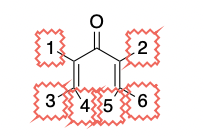

## 2.2) Hammet Parameters
https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cmtd.202200041


https://peter-ertl.com/molecular/substituents/sigmas.html


In [ ]:
## sigma-m sigma-p hansch-pi
hammetls = {'[H][H]':[0.092,0.096,0.174],
            'C':[-0.03,-0.148,0.256],
            'c1ccccc1':[0.055,0.012,1.953],
            'sub- c1ccccc1':[0.055,0.012,1.953],
            'OC':[0.029,-0.331,2.15],
            'C(=O)OC':[0.107,0.026,0.118],
            'CC':[-0.059,-0.17,0.632],
            'CCCC':[-0.043,-0.157,1.694],
            'C1CC=CCC1':[-0.008,-0.087,2.155], 
            'C(C)(C)':[-0.036,-0.121,0.995],
            'SC':[0.073,-0.119,0.756],
            'C#N':[0.526,0.618,0.028],
            'O':[0.052,-0.325,-0.061],
            'COC1=CC(OC)=CC(OC)=C1':[0.106,0.019,1.966],
            'C1=CCCC1':[0.009,-0.064,1.177], ## SMILES: [R]C1=CCCC1, sigma-m: 0.009, sigma-p: -0.064, pi: 1.177
            '2- C1CCC=CO1':[0.087,0.035,1.116], ## SMILES: [R]C1=CCCCO1, sigma-m: 0.087, sigma-p: 0.035, pi: 1.116 
            '3- C1CCC=CO1':[-0.031,-0.136,0.549], ## SMILES: [R]C1=COCCC1, sigma-m: -0.031, sigma-p: -0.136, pi: 0.549 
            '3- C1=CNC=C1':[-0.078,-0.211,0.797], ## SMILES: [R]c1cc[nH]c1, sigma-m: -0.078, sigma-p: -0.211, pi: 0.797 
            '2- C1=CNC=C1':[-0.008,-0.13,0.992], ## SMILES: [R]c1ccc[nH]1, sigma-m: -0.008, sigma-p: -0.130, pi: 0.992 
            'C3- C1=COC=C1':[0.062,-0.002,0.9], ## SMILES: [R]c1ccoc1, sigma-m: 0.062, sigma-p: -0.002, pi: 0.9
            'C2- C1=COC=C1':[0.142,0.081,1.095], ## SMILES: [R]c1ccco1, sigma-m: 0.142, sigma-p: 0.081, pi: 1.095
            'C[Si](C)C':[-0.114,-0.056,2.545], ## SMILES: C[Si](C)(C)[R], sigma-m: -0.114, sigma-p: -0.056, pi: 2.545
            'O=[P](OC)OC':[0.401,0.464,-0.475], ## SMILES: COP(=O)([R])OC, sigma-m: 0.401, sigma-p: 0.464, pi: -0.475 
            '2- C1=CC=CC=N1':[0.104,0.125,1.054],## SMILES: [R]c1ccccn1, sigma-m: 0.104, sigma-p: 0.125, pi: 1.054
            '4- C1=CC=CC=N1':[0.171,0.185,0.664], ## SMILES: [R]c1ccncc1, sigma-m: 0.171, sigma-p: 0.185, pi: 0.664
            '3- C1=CC=CC=N1':[0.149,0.116,0.882 ], ## SMILES: [R]c1cccnc1, sigma-m: 0.149, sigma-p: 0.116, pi: 0.882 
            'C2- C1=CC=CC=N1':[0.104,0.125,1.054],## SMILES: [R]c1ccccn1, sigma-m: 0.104, sigma-p: 0.125, pi: 1.054
            'C4- C1=CC=CC=N1':[0.171,0.185,0.664], ## SMILES: [R]c1ccncc1, sigma-m: 0.171, sigma-p: 0.185, pi: 0.664
            'C3- C1=CC=CC=N1':[0.149,0.116,0.882 ], ## SMILES: [R]c1cccnc1, sigma-m: 0.149, sigma-p: 0.116, pi: 0.882 
            'C=C':[0.070,0.024,0.559], ## SMILES: C=C[R], sigma-m: 0.070, sigma-p: 0.024, pi: 0.559
            '3- C1=COC=C1':[0.062,-0.002,0.9], ## SMILES: [R]c1ccoc1, sigma-m: 0.062, sigma-p: -0.002, pi: 0.9
            '2- C1=CC=CO1':[0.142,0.081,1.095], ## SMILES: [R]c1ccco1, sigma-m: 0.142, sigma-p: 0.081, pi: 1.095
            '4- C1=CC=NC=N1':[0.246,0.334,0.152], ## SMILES: [R]c1ccncn1, sigma-m: 0.246, sigma-p: 0.334, pi: 0.152
            '5- C1=CC=NC=N1':[0.261,0.249,0.174], ## SMILES: [R]c1cncnc1, sigma-m: 0.261, sigma-p: 0.249, pi: 0.174
            '6- COC1=CC(OC)=CC=C1':[0.074,0.030,1.995 ], ## SMILES: COc1cc([R])cc(OC)c1, sigma-m: 0.074, sigma-p: 0.030, pi: 1.995 
            '5- COC1=CC(OC)=CC=C1':[0.035,-0.046,1.995], ## SMILES: COc1ccc([R])c(OC)c1, sigma-m: 0.035, sigma-p: -0.046, pi: 1.995
            'O=C1OCNC1':[0.154,0.100,-0.273], ## SMILES: O=C1OCNC1[R], sigma-m: 0.154, sigma-p: 0.100, pi: -0.273 
            'C1(CC2=CC=CC=C2)=CC=CC=C1':[0.042,-0.054,3.433], ## SMILES: [R]C(c1ccccc1)c2ccccc2, sigma-m: 0.042, sigma-p: -0.054, pi: 3.433
            'C1CCC1':[-0.010,-0.114,0.916], ## SMILES: [R]C1CCC1, sigma-m: -0.010, sigma-p: -0.114, pi: 0.916
            'C1(C=CC=C2)=C2SC=N1':[0.338,0.390,2.511], ## SMILES: [R]c2nc1ccccc1s2, sigma-m: 0.338, sigma-p: 0.390, pi: 2.511 
            'C4- BrC1=CC=CC=C1':[0.154,0.145,2.762], ## SMILES: Brc1ccc([R])cc1, sigma-m: 0.154, sigma-p: 0.145, pi: 2.762
            '4- FC(C1=CC=CC=C1)(F)F':[0.193,0.205,2.849], ## SMILES: FC(F)(F)c1ccc([R])cc1, sigma-m: 0.193, sigma-p: 0.205, pi: 2.849 
            '3- FC(C1=CC=CC=C1)(F)F':[0.198,0.173,2.825], ## SMILES: FC(F)(F)c1cccc([R])c1, sigma-m: 0.198, sigma-p: 0.173, pi: 2.825
            'NC=O':[0.207,0.304,-0.468], ## SMILES: NC(=O)[R], sigma-m: 0.207, sigma-p: 0.304, pi: -0.468
            '2- C1=CC=CS1':[0.147,0.090,1.737], ## SMILES: [R]c1cccs1, sigma-m: 0.147, sigma-p: 0.090, pi: 1.737
            '3- C1=CC=CS1':[0.068,0.011,1.541], ## SMILES: [R]c1ccsc1, sigma-m: 0.068, sigma-p: 0.011, pi: 1.541
            'C#C':[0.213,0.155,0.036], ## SMILES: C#C[R], sigma-m: 0.213, sigma-p: 0.155, pi: 0.036
            '[NH2]':[-0.125,-0.570,-0.359], ## SMILES: N[R], sigma-m: -0.125, sigma-p: -0.570, pi: -0.359
            '[NH]C':[-0.174,-0.624,0.016], ## SMILES: CN[R], sigma-m: -0.174, sigma-p: -0.624, pi: 0.016
            'CC(C)C':[-0.061,-0.144,1.442], ## SMILES: CC(C)(C)[R], sigma-m: -0.061, sigma-p: -0.144, pi: 1.442
            'F':[0.371,0.129,0.322], ## SMILES: F[R], sigma-m: 0.371, sigma-p: 0.129, pi: 0.322 
            'Br':[0.392,0.282,0.967], ## SMILES: Br[R], sigma-m: 0.392, sigma-p: 0.282, pi: 0.967
            'C(F)(F)(F)':[0.547,0.647,1.169], ## SMILES: FC(F)(F)[R], sigma-m: 0.547, sigma-p: 0.647, pi: 1.169 
            'C(F)(F)(F)(F)':[0.547,0.647,1.169], ## SMILES: FC(F)(F)[R], sigma-m: 0.547, sigma-p: 0.647, pi: 1.169 
            'O=C1OCC[N]1':[0.151,-0.045,-0.029],## sigma-m: 0.151, sigma-p: -0.045, pi: -0.029 
            'Cl':[0.378, 0.200, 0.836],## Cl[R], sigma-m: 0.378, sigma-p: 0.200, pi: 0.836
            'ClCl':[0.378, 0.200, 0.836]## Cl[R], sigma-m: 0.378, sigma-p: 0.200, pi: 0.836
           }

hammetlsNOpi = {k:v[:-1] for k,v in hammetls.items()}
sigmpap = [v[1] for v in hammetls.values()]


## 2.3) Loss of Aromaticity
1 yes

0 no

In [ ]:
aromLoss = {'[H][H]':[0],
            'C':[0],
            'c1ccccc1':[1],
            'sub- c1ccccc1':[0],
            'OC':[0],
            'C(=O)OC':[0],
            'CC':[0],
            'CCCC':[0],
            'C1CC=CCC1':[0], 
            'C(C)(C)':[0],
            'SC':[0],
            'C#N':[0],
            'O':[0],
            'COC1=CC(OC)=CC(OC)=C1':[0],
            'C1=CCCC1':[0], ##
            '2- C1CCC=CO1':[0], 
            '3- C1CCC=CO1':[0], 
            '3- C1=CNC=C1':[1], 
            '2- C1=CNC=C1':[1], 
            'C3- C1=COC=C1':[0],
            'C2- C1=COC=C1':[0], 
            'C[Si](C)C':[0],
            'O=[P](OC)OC':[0], 
            '2- C1=CC=CC=N1':[1],
            '4- C1=CC=CC=N1':[1], 
            '3- C1=CC=CC=N1':[1], 
            'C2- C1=CC=CC=N1':[0],
            'C4- C1=CC=CC=N1':[0], 
            'C3- C1=CC=CC=N1':[0], 
            'C=C':[0], 
            '3- C1=COC=C1':[1],
            '2- C1=CC=CO1':[1], 
            '4- C1=CC=NC=N1':[1],
            '5- C1=CC=NC=N1':[1], 
            '5- COC1=CC(OC)=CC=C1':[1],  
            '4- COC1=CC(OC)=CC=C1':[1], 
            '6- COC1=CC(OC)=CC=C1':[1], 
            'O=C1OCNC1':[0],
            'C1(CC2=CC=CC=C2)=CC=CC=C1':[0],
            'C1CCC1':[0],
            'C1(C=CC=C2)=C2SC=N1':[0], 
            'C4- BrC1=CC=CC=C1':[0],
            '4- FC(C1=CC=CC=C1)(F)F':[1], 
            '3- FC(C1=CC=CC=C1)(F)F':[1],
            'NC=O':[0], 
            '2- C1=CC=CS1':[1], 
            '3- C1=CC=CS1':[1],
            'C#C':[0],
            '[NH2]':[0], 
            '[NH]C':[0],
            'CC(C)C':[0], 
            'Br':[0],
            'F':[0],
            'C(F)(F)(F)':[0],
            'C(F)(F)(F)(F)':[0],
            'O=C1OCC[N]1':[0],
            'ClCl':[0],
            'Cl':[0]
           }


## 2.4) RDKit Features

In [ ]:
descriptor_list_2d_best9 = ['MaxAbsEStateIndex', 'MinAbsEStateIndex']

rdkitfeatures9 = {k:[] for k in aromLoss.keys()}
for k in rdkitfeatures9.keys():
    mol = Chem.MolFromSmiles(k.split()[-1])
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    rdkitfeatures9[k] =[getattr(Descriptors, x)(mol) for x in descriptor_list_2d_best9]


## 2.5) Sterimol
These are loaded in from another file before training

# 3) Model Training and Testing
### Match the substituent name with the associated SMILES
This is neccesary because some substituents can share SMILES and this system also makes it easier on the fly to evaluate the substitution of a molecule.

In [ ]:
smiles2sub = {'furan2': '2- C1=CC=CO1',
 'thiophene2': '2- C1=CC=CS1',
 'pyrrole2': '2- C1=CNC=C1',
 'ocyclohex2': '2- C1CCC=CO1',
 'thiophene3': '3- C1=CC=CS1',
 'pyrrole3': '3- C1=CNC=C1',
 'furan3': '3- C1=COC=C1',
 'ocyclohex3': '3- C1CCC=CO1',
 'phcf33': '3- FC(C1=CC=CC=C1)(F)F',
 'diazine124': '4- C1=CC=NC=N1',
 'o2ph5': '5- COC1=CC(OC)=CC=C1',
 'phcf34': '4- FC(C1=CC=CC=C1)(F)F',
 'diazine125': '5- C1=CC=NC=N1',
 'o2ph6': '6- COC1=CC(OC)=CC=C1',
 'br':'Br',
 'c': 'C',
 'alkyne': 'C#C',
 'cn': 'C#N',
 'co2me': 'C(=O)OC',
 'ipr': 'C(C)(C)',
 'snindole': 'C1(C=CC=C2)=C2SC=N1',
 'cph2': 'C1(CC2=CC=CC=C2)=CC=CC=C1',
 'cyclopen': 'C1=CCCC1',
 'cyclohex': 'C1CC=CCC1',
 'cyclobut': 'C1CCC1',
 'pyridine2': '2- C1=CC=CC=N1',
 'pyridine3': '3- C1=CC=CC=N1',
 'pyridine4': '4- C1=CC=CC=N1',
 'cpyridine2': 'C2- C1=CC=CC=N1',
 'cpyridine3': 'C3- C1=CC=CC=N1',
 'cpyridine4': 'C4- C1=CC=CC=N1',
 'cfuran2': 'C2- C1=COC=C1',
 'cfuran3': 'C3- C1=COC=C1',
 'cphbr': 'C4- BrC1=CC=CC=C1',
 'db': 'C=C',
 'et': 'CC',
 'tbut': 'CC(C)C',
 'but': 'CCCC',
 'o3ph': 'COC1=CC(OC)=CC(OC)=C1',
 'sim3': 'C[Si](C)C',
 'f':'F',
 'amide': 'NC=O',
 'o': 'O',
 'cylactam': 'O=C1OCNC1',
 'po3': 'O=[P](OC)OC',
 'ome': 'OC',
 'sme': 'SC',
 'h': '[H][H]',
 'nh2': '[NH2]',
 'nh1': '[NH]C',
 'ph': 'c1ccccc1',
 'phsub': 'sub- c1ccccc1',
 'cf3':'C(F)(F)(F)',
 'cylactamN':'O=C1OCC[N]1',
 'cl':'Cl'}

In [ ]:
### Read in Sterimol data and average across different conformations ad distant atoms
df_dub = pd.read_csv('DBStep_Parameters_GitHub.csv')
### Group by SMILES, mean, drop unncesary columns
df_dub['smilesindex'] = df_dub.apply (lambda row: row['smiles'].split('_')[0], axis=1)
df_dub = df_dub.set_index('smilesindex')
### Average the sterimol data when we have multiple possible values. This is important when there are multiple possible
### longest paths in the molecule of equal length
df_dub = df_dub.groupby(df_dub.index).mean() 
df_dub = df_dub[['L', 'Bmin', 'Bmax']] 
df_dub
dubresults = df_dub.T.to_dict() ## SMILES as key and sterimol values as value

### Convert substituents to SMILES (ex: Me -> C)
### This means that the Sterimol data is in the same format as the other feature dictionaries
substituents = {k:[smiles2sub[x] for x in v] for k,v in substituents_orig.items()}

### For each structure, collate the features for each substituent using the various feature dictionaries
bh_feat = {k:[list(dubresults[x.split()[-1]].values())+list(hammetls[x]) + list(aromLoss[x]) + list(rdkitfeatures9[x])  for x in substituents[k]] + [[v[1]]] for k,v in dataset.items()} ## sterics and dipole
### Unpack nested lists
bh_feat = {k:[x for y in v for x in y] for k,v in bh_feat.items()}
### Calculate the number of features for each location on the divinyl ketone
featpersec = int((len(bh_feat[1])-1)/6)

#### Option A: "Inverse" dataset
### convert to dataframe with rows being each molecule
df_bh_feat = pd.DataFrame(bh_feat).T
### Prepare the inversed dataframe
df_bh_feat_inverse = copy.copy(df_bh_feat)
### Swap the alpha, beta-trans, and beta-cis feature sections to create "inverse" molecule
df_bh_feat_inverse = swap_sections(df_bh_feat_inverse, 0, 1, features_per_section=featpersec)
df_bh_feat_inverse = swap_sections(df_bh_feat_inverse, 2, 5, features_per_section=featpersec)
df_bh_feat_inverse = swap_sections(df_bh_feat_inverse, 3, 4, features_per_section=featpersec)
### Rename columns (important so that concatenation does not simply duplicate dataset)
df_bh_feat_inverse.columns = list(range(df_bh_feat_inverse.shape[1]))
df_bh_feat_inverse = pd.concat([df_bh_feat,df_bh_feat_inverse])
df_bh_feat_inverse = df_bh_feat_inverse.reset_index(drop=True)

#### Option B: Averaged dataset
### Collate features for each structure
bh_feat_avg = {k:[list(dubresults[x.split()[-1]].values())+list(hammetls[x]) + list(aromLoss[x])+ list(rdkitfeatures9[x]) for x in substituents[k]] + [[v[1]]] for k,v in dataset.items()} ## sterics and dipole
### Average the features across each substituent location (alpha, beta-trans, beta-cis)
bh_feat_avg = {k:[averagebetween2lists(v[0],v[1]),averagebetween2lists(v[2],v[5]),averagebetween2lists(v[3],v[4]),v[-1]] for k,v in bh_feat_avg.items()}
### Unpack nested arrays
bh_feat_avg = {k:[x for y in v for x in y] for k,v in bh_feat_avg.items()}
df_bh_feat_avg = pd.DataFrame(bh_feat_avg).T

print(df_bh_feat_avg.shape)
print(df_bh_feat_inverse.shape)

### Conduct K-folds for average dataset
print('Averaged results (Not used in manuscript)')
kfoldresults = test_kfolds(df_bh_feat_avg)
### Calculate and print overall results
overallmeanR2 = np.mean([x for y in kfoldresults[0].values() for n,x in enumerate(y) if n%2 ==0])
overallstdR2 = np.std([x for y in kfoldresults[0].values() for n,x in enumerate(y) if n%2 ==0])
overallmeanMAE = np.mean([x for y in kfoldresults[0].values() for n,x in enumerate(y) if n%2 ==1])
overallstdMAE = np.std([x for y in kfoldresults[0].values() for n,x in enumerate(y) if n%2 ==1])
print(f'Overall Valid R2: {overallmeanR2:.2f} ± {overallstdR2:.2f}')
print(f'Overall Valid MAE: {overallmeanMAE:.2f} ± {overallstdMAE:.2f}')

### Conduct K-folds for "inverse" dataset
print('\n Inverse results (Used in manuscript)')
### Calculate and print overall results
kfoldresults = test_kfoldsINVERSE(df_bh_feat_avg,df_bh_feat_inverse)
overallmeanR2 = np.mean([x for y in kfoldresults[0].values() for n,x in enumerate(y) if n%2 ==0])
overallstdR2 = np.std([x for y in kfoldresults[0].values() for n,x in enumerate(y) if n%2 ==0])
overallmeanMAE = np.mean([x for y in kfoldresults[0].values() for n,x in enumerate(y) if n%2 ==1])
overallstdMAE = np.std([x for y in kfoldresults[0].values() for n,x in enumerate(y) if n%2 ==1])
print(f'Overall Valid R2: {overallmeanR2:.2f} ± {overallstdR2:.2f}')
print(f'Overall Valid MAE: {overallmeanMAE:.2f} ± {overallstdMAE:.2f}')

## Building Models for Each Structure

In [ ]:
### Build model for each structure using shape of original dataset to count the number of structures and the inverse dataset
### to build the model from.
MAEonetestresults,onetestresults,featureimp,predls,modelsls = test_all(df_bh_feat.shape[0],df_bh_feat_inverse)

### Optional code to save data for later use 
# RFinverseOneTestResults = (MAEonetestresults,onetestresults,featureimp,predls)
# with open('tempfiles/RFinverseOneTestResults272.pkl','wb') as handle:
#     pickle.dump(RFinverseOneTestResults, handle, protocol=pickle.HIGHEST_PROTOCOL)
### Optional approach to loading data
# with open('tempfiles/RFinverseOneTestResults272.pkl', 'rb') as handle:
#     MAEonetestresults,onetestresults,featureimp,predls = pickle.load(handle)


In [ ]:
plot_results = {}

### Gather MAE for each structure
for k,v in dict(zip(dataset.keys(),onetestresults.keys())).items():
    ### Structure ID = MAE for structure ID (after converting to index)
    plot_results[k] = onetestresults[v]

### Plot data
plot_dict_first_elements2(newplotdic,figsize=(25, 3))

### Print mean
print(round(statistics.mean([x[0] for x in onetestresults.values()]),1))

# 3) Making New Predictions
The following naming scheme is used for the substituents:
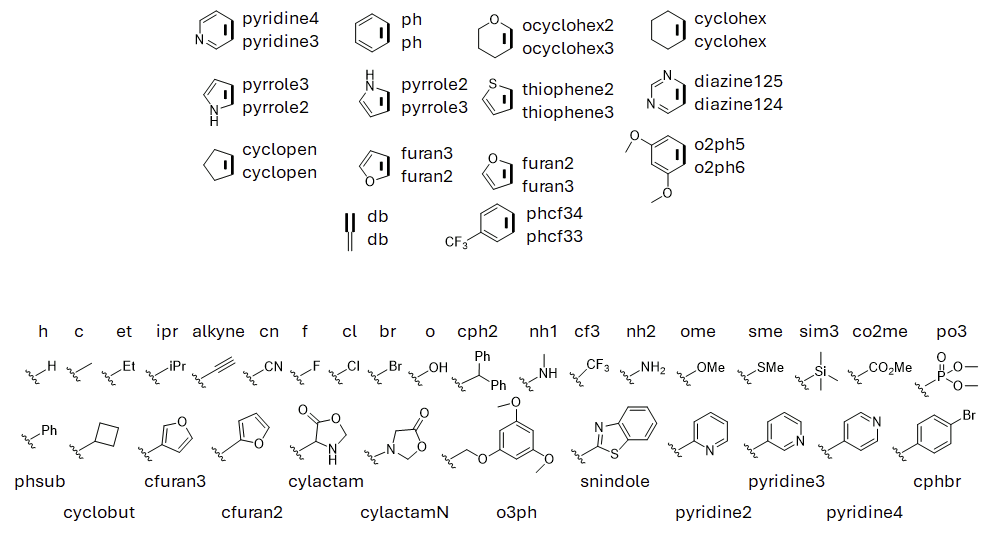

In [ ]:
test_new_molecule(['h','h','h','h','h','h'],df_bh_feat_inverse,smiles2sub)
test_new_molecule(['c','sme','sme','h','h','sme'],df_bh_feat_inverse,smiles2sub)
